# Building Skill Network

In [1]:
import numpy as np
import ast
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import plotly.graph_objects as go
#import community
import networkx as nx
%matplotlib inline

## Loading Data

In [609]:
df = pd.read_json("full_data.json")

In [705]:
hello = pd.read_json("full_data_3.json")
hello.shape

(748785, 19)

## [For subset of df]

In [ ]:
df = df.iloc[0:10000]
df.shape

## Create Skill Columns

### Collect all unique skills in a list

In [4]:
# Collect all unique skills in a list

def unique_skills(df):
    
    list_of_skills = []

    for index, row in df.skills.iteritems():

        if  isinstance(row,list):

            for skill in row:
                if skill not in list_of_skills:
                    list_of_skills.append(skill)
                    #print("success", skill, len(list_of_skills))
                else:
                    pass

        if  isinstance(row,str):

            if row not in list_of_skills:
                    list_of_skills.append(row)
                    #print("success", row, len(list_of_skills))
            else:
                    pass
        else:
            #print(row, type(row))
            pass 
    return list_of_skills

### Count how often each skill occurs

In [5]:
# Count how many times each skill occurs


def skill_count(list_of_skills,df):

    skill_dict = { i : 0 for i in list_of_skills }

    for index, row in df.skills.iteritems():

        if  isinstance(row,list):

            for skill in row:
                skill_dict[skill] += 1

        if  isinstance(row,str):

            skill_dict[row] += 1

        else:
            pass   
    return skill_dict

In [6]:
# Exclude all skills that only occur once
skill_count = pd.DataFrame.from_dict(skill_dict, orient='index',columns=['count'])
skill_columns = skill_count[skill_count['count'] > 1].index

### Create skill columns

In [6]:
# Defining function
def skill_col(df,skill_columns):
    
        for i in skill_columns:
            df[i]= 0 
    
    
        for skill in skill_columns:

            for index, row in df.skills.dropna().iteritems():

                if skill in row:
                    df.loc[index,(skill)]=1
        
        return df

In [8]:
# Creating skill columns
df = skill_col(df, skill_columns)

## Create Adj. Matrix

In [7]:
def adj_matrix(df):
    
    temp = df.iloc[:,7:]
    adj = temp.T.dot(temp)
    return adj 

In [10]:
matrix_adj = adj_matrix(df)

## Create Edge list and Calculate Lift weight

In [8]:
# construct edge list from adjaciency matrix

def edge_list(df_adj):

    # unstack adjaciency matrix
    adj_unstacked = df_adj.stack().to_frame().reset_index()
    adj_unstacked.rename(columns = {'level_0':'skill_a', 'level_1':'skill_b'},inplace = True)
    
    # extract total count of each skill from unstacked adjaciency matrix
    skill_tot = adj_unstacked[adj_unstacked['skill_a']==adj_unstacked['skill_b']][['skill_a',0]]
    skill_tot.rename(columns = {'skill_a':'skill'}, inplace = True)
    
    # extract count of skill combinations from unstacked adjaciency matrix
    skill_combinations = adj_unstacked[adj_unstacked['skill_a']!=adj_unstacked['skill_b']][['skill_a','skill_b',0]]
    skill_combinations.rename(columns = {0:'together'}, inplace = True)
    
    # create edge list by merging count of skill combinations and total count of skill a
    edge_list = skill_combinations.merge(skill_tot, left_on = 'skill_a', right_on = 'skill', left_index = True)
    edge_list.drop('skill', axis = 1, inplace = True)
    edge_list.rename(columns = {0:'skill_a_count'}, inplace = True)
    
    # merge count of skill b and order by skill_a_count
    edge_list = edge_list.merge(skill_tot, left_on = 'skill_b', right_on = 'skill', left_index = True)
    edge_list.drop('skill', axis = 1, inplace = True)
    edge_list.rename(columns = {0:'skill_b_count'}, inplace = True)
    edge_list.sort_values('skill_a_count', ascending = False, inplace = True)
    
    # calculate lift weight (multiplied by 100)
    edge_list['lift_weight'] = 100 * edge_list['together'] / (edge_list['skill_a_count'] * edge_list['skill_b_count'])
    
    # remove unnecessary columns
    edge_list = edge_list[['skill_a','skill_b','lift_weight']]
    
    # remove rows where lift_weight is zero
    edge_list_final = edge_list[edge_list['lift_weight'] != 0]
    
    return edge_list_final

In [102]:
# edge list with Anderson weighting

def edge_list_anderson(df_adj):

    # unstack adjaciency matrix
    adj_unstacked = df_adj.stack().to_frame().reset_index()
    adj_unstacked.rename(columns = {'level_0':'skill_a', 'level_1':'skill_b'},inplace = True)
    
    # extract total count of each skill from unstacked adjaciency matrix
    skill_tot = adj_unstacked[adj_unstacked['skill_a']==adj_unstacked['skill_b']][['skill_a',0]]
    skill_tot.rename(columns = {'skill_a':'skill'}, inplace = True)
    
    # extract count of skill combinations from unstacked adjaciency matrix
    skill_combinations = adj_unstacked[adj_unstacked['skill_a']!=adj_unstacked['skill_b']][['skill_a','skill_b',0]]
    skill_combinations.rename(columns = {0:'together'}, inplace = True)
    
    # create edge list by merging count of skill combinations and total count of skill a
    edge_list = skill_combinations.merge(skill_tot, left_on = 'skill_a', right_on = 'skill', left_index = True)
    edge_list.drop('skill', axis = 1, inplace = True)
    edge_list.rename(columns = {0:'skill_a_count'}, inplace = True)
    
    # merge count of skill b and order by skill_a_count
    edge_list = edge_list.merge(skill_tot, left_on = 'skill_b', right_on = 'skill', left_index = True)
    edge_list.drop('skill', axis = 1, inplace = True)
    edge_list.rename(columns = {0:'skill_b_count'}, inplace = True)
    edge_list.sort_values('skill_a_count', ascending = False, inplace = True)
    
    # calculate Anderson weight
    
    # if count a is smaller than b, take a otherwise b
    edge_list['normalizer'] = np.where((edge_list['skill_a_count'] < edge_list['skill_b_count']), 
                                       edge_list['skill_a_count'], edge_list['skill_b_count'])
    

    edge_list['A_weight'] = edge_list['together'] / edge_list['normalizer']
    
    # remove unnecessary columns
    edge_list = edge_list[['skill_a','skill_b','A_weight']]
    
    # remove rows where lift_weight is zero
    edge_list_final = edge_list[edge_list['A_weight'] != 0]
    
    return edge_list_final

In [13]:
edge_L = edge_list(matrix_adj)

## Create Network

In [14]:
G=nx.from_pandas_edgelist(edge_L, source='skill_a', target='skill_b', edge_attr="lift_weight")

In [20]:
nx.write_graphml(G, "skill_network.graphml")

## Create Louvain Partition

In [17]:
import community

In [18]:
partition = community.best_partition(G)
    
nx.set_node_attributes(G, partition, name = 'louvain_partition')

In [19]:
# calculate modularity
community.modularity(partition, G, weight='weight')

0.4527562891510732

# Run on entire Dataframe

Creating adj. matrix on full dataframe requires to much RAM for my computer. Therefore, I split the dataframe in smaller chunks and then add up the adj. matrices to create the network.

In [32]:
df = pd.read_json("full_data.json")

#### Preparation on full df

In [9]:
# list of skills
list_of_skills = unique_skills(df)

# skill count
skill_dict = skill_count(list_of_skills,df)

# Exclude all skills that only occur once
skill_count = pd.DataFrame.from_dict(skill_dict, orient='index',columns=['count'])
skill_columns = skill_count[skill_count['count'] > 1].index

#### Split dataframe (DONE)

In [24]:
df_list = np.array_split(df, 150)

#### Run on all subsets and collect all adj. matrices in a list (DONE)

In [52]:
list_adj_matrices = []

for index,dataframe in enumerate(df_list):
    
    print('starting:',index)
    
    dataframe = skill_col(dataframe, skill_columns)
    print(index,'Done with skill columns')
    
    matrix_adj = adj_matrix(dataframe)
    print(index,'Done with adj. matrix')
    
    del dataframe
    
    list_adj_matrices.append(matrix_adj)
    
    print('Done one df')
    

starting: 0
0 Done with skill columns
0 Done with adj. matrix
Done one df
starting: 1
1 Done with skill columns
1 Done with adj. matrix
Done one df
starting: 2
2 Done with skill columns
2 Done with adj. matrix
Done one df
starting: 3
3 Done with skill columns
3 Done with adj. matrix
Done one df
starting: 4
4 Done with skill columns
4 Done with adj. matrix
Done one df
starting: 5
5 Done with skill columns
5 Done with adj. matrix
Done one df
starting: 6
6 Done with skill columns
6 Done with adj. matrix
Done one df
starting: 7
7 Done with skill columns
7 Done with adj. matrix
Done one df
starting: 8
8 Done with skill columns
8 Done with adj. matrix
Done one df
starting: 9
9 Done with skill columns
9 Done with adj. matrix
Done one df
starting: 10
10 Done with skill columns
10 Done with adj. matrix
Done one df
starting: 11
11 Done with skill columns
11 Done with adj. matrix
Done one df
starting: 12
12 Done with skill columns
12 Done with adj. matrix
Done one df
starting: 13
13 Done with ski

In [53]:
# Save list of adj matrices
import pickle

filename = 'list_of_adj'
outfile = open(filename,'wb')
pickle.dump(list_adj_matrices,outfile)
outfile.close()

#### Add all adj. matrices together

In [71]:
combined_adj_matrix = sum(list_adj_matrices)

In [81]:
# Save it
combined_adj_matrix.to_csv("combined_adj_matrix.csv")

In [10]:
# Reload it
final_adj_matrix = pd.read_csv("combined_adj_matrix.csv")
final_adj_matrix.set_index('Unnamed: 0', inplace=True)
final_adj_matrix.index.name = None

### Create Edge_list (lift weight)

In [13]:
edge_L = edge_list(final_adj_matrix)

### Create Edge_list (Anderson weighting)

In [103]:
edge_L_A = edge_list_anderson(final_adj_matrix)

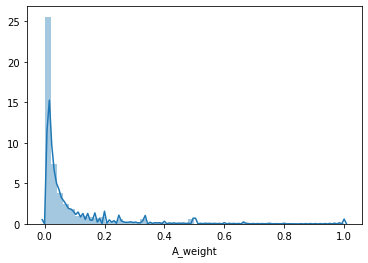

In [104]:
sns.distplot(edge_L_A["A_weight"])

## Create Network

In [327]:
test_edge = edge_L[edge_L["lift_weight"]> 0.005]

In [328]:
# test with lift > 0.005
test_G=nx.from_pandas_edgelist(test_edge, source='skill_a', target='skill_b', edge_attr="lift_weight")

In [ ]:
# normal Graph

In [25]:
G=nx.from_pandas_edgelist(edge_L, source='skill_a', target='skill_b', edge_attr="lift_weight")

In [85]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 6254\nNumber of edges: 536231\nAverage degree: 171.4842'

In [108]:
# Anderson weight network
G_A=nx.from_pandas_edgelist(edge_L_A, source='skill_a', target='skill_b', edge_attr="A_weight")

In [109]:
nx.info(G_A)

'Name: \nType: Graph\nNumber of nodes: 6254\nNumber of edges: 536231\nAverage degree: 171.4842'

### Network Analysis

In [111]:
# function to obtain all network metrics

def analyse_network(G,skill_dict,name):
    
    # Add skill count as node attribute
    nx.set_node_attributes(G, skill_dict, name = 'count')
    
    degree_C = nx.degree_centrality(G)
    between_C = nx.betweenness_centrality(G)
    
    nx.set_node_attributes(G, degree_C, name = 'degree_centrality')
    nx.set_node_attributes(G, between_C, name = 'between_centrality')
    
    # Calculate combination of centrality and skill count

    centrality = pd.DataFrame(between_C,index=[0])
    centrality = centrality.T
    centrality.reset_index(inplace=True)
    centrality.rename(columns={'index': 'skills', 0: 'centrality'}, inplace=True)

    S_count = pd.DataFrame(skill_dict,index=[0])
    S_count = S_count.T
    S_count.reset_index(inplace=True)
    S_count.rename(columns={'index': 'skills', 0: 'count'}, inplace=True)

    centrality = centrality.merge(S_count, on='skills')

    centrality['score'] = centrality['centrality']*centrality['count']

    del centrality['count']
    del centrality['centrality']

    centrality.set_index('skills', inplace=True)
    score = centrality.to_dict()
    score = score["score"]

    nx.set_node_attributes(G, score, name = 'centrality_count_score')
    
    
    import community
    
    partition = community.best_partition(G)
    
    nx.set_node_attributes(G, partition, name = 'louvain_partition')
    
    # calculate modularity
    print('modularity:',community.modularity(partition, G, weight='weight'))
    
    # Find unique number of partitions
    df_partition = pd.DataFrame(partition,index=[0])
    df_partition = df_partition.T
    df_partition.reset_index(inplace=True)
    df_partition.rename(columns={'index': 'skills', 0: 'partition'}, inplace=True)
    print("There are",len(df_partition.partition.unique()),"partitions in the skill network.")
    
    nx.write_graphml(G, name+".graphml")
    
    return partition, df_partition


In [112]:
partition_A, df_partition_A = analyse_network(G_A,skill_dict,"skill_network_anderson")

modularity: 0.30756239155441706
There are 7 partitions in the skill network.


In [329]:
partition_test, df_partition_test = analyse_network(test_G,skill_dict,"test_graph2")

modularity: 0.5524645719897614
There are 12 partitions in the skill network.


# Manual Network Analysis

### Calculate Centrality

In [ ]:
# Add skill count as node attribute
nx.set_node_attributes(G, skill_dict, name = 'count')

In [39]:
degree_C = nx.degree_centrality(G)
between_C = nx.betweenness_centrality(G)

In [40]:
nx.set_node_attributes(G, degree_C, name = 'degree_centrality')
nx.set_node_attributes(G, between_C, name = 'between_centrality')

In [84]:
# Calculate combination of centrality and skill count

centrality = pd.DataFrame(between_C,index=[0])
centrality = centrality.T
centrality.reset_index(inplace=True)
centrality.rename(columns={'index': 'skills', 0: 'centrality'}, inplace=True)

S_count = pd.DataFrame(skill_dict,index=[0])
S_count = S_count.T
S_count.reset_index(inplace=True)
S_count.rename(columns={'index': 'skills', 0: 'count'}, inplace=True)

centrality = centrality.merge(S_count, on='skills')

centrality['score'] = centrality['centrality']*centrality['count']

del centrality['count']
del centrality['centrality']

centrality.set_index('skills', inplace=True)
score = centrality.to_dict()
score = score["score"]

nx.set_node_attributes(G, score, name = 'centrality_count_score')

## Create Louvain Partition

In [31]:
import community

In [693]:
partition = community.best_partition(G,resolution=0.7) # ,weight='lift_weight'
    
#nx.set_node_attributes(G, partition, name = 'louvain_partition')

In [695]:
# calculate modularity
community.modularity(partition, G, weight='lift_weight')

0.5974445127325544

In [696]:
# Find unique number of partitions
df_partition = pd.DataFrame(partition,index=[0])
df_partition = df_partition.T
df_partition.reset_index(inplace=True)
df_partition.rename(columns={'index': 'skills', 0: 'partition'}, inplace=True)
len(df_partition.partition.unique())

13

### Save network

In [704]:
nx.write_graphml(G, "skill_network_lift2.graphml")

# Data Analysis and Transfer

In [361]:
ds = [partition,degree_C,between_C,skill_dict]
d = {}
for k in partition.keys():
    d[k] = tuple(d[k] for d in ds)

In [537]:
df_network = pd.DataFrame(d)
df_network = df_network.T
df_network.reset_index(inplace=True)
df_network.rename(columns={'index': 'skills', 0: 'partition',1: 'degree_centrality',2: 'between_centrality',3:'count'}, inplace=True)

df_network["partition"] = df_network["partition"].astype("int")
df_network["partition"] = df_network["partition"].astype("str")

In [538]:
df_network.head()

,skills,partition,degree_centrality,between_centrality,count
0,wordpress,0,0.488725,2.096069e-02,74289.0
1,requirements-specification,1,0.030545,1.233838e-05,64.0
2,oracle-database-administration,2,0.023829,1.910433e-04,68.0
3,wamp,1,0.005757,5.939722e-07,10.0
4,asp.net,1,0.134975,7.896476e-04,2702.0


## Find top skills in each partition

Sorting by count or by centrality yields almost the same results as the two are highly correlated

In [302]:
pd.set_option('display.max_rows', 100)

In [539]:
# show number of skills in each partition
df_network.groupby(['partition'],as_index=False) \
       .agg({'skills':'size'})

,partition,skills
0,0,260
1,1,1434
2,10,18
3,11,68
4,12,7
5,2,553
6,3,688
7,4,884
8,5,855
9,6,881


In [365]:
# Partition 0 - UI Design and App Design
# Under 0.7 - UI Design and App Design
df_network[df_network["partition"]=="0"].sort_values(by=['count',],ascending=False).head(15)

,skills,partition,degree_centrality,between_centrality,count
0,wordpress,0,0.488725,0.020961,74289.0
1291,html,0,0.458660,0.016231,46493.0
2813,shopify,0,0.252199,0.002746,16812.0
2557,data-scraping,0,0.198305,0.001971,7862.0
2255,woocommerce,0,0.169679,0.000973,7158.0
2251,ui-design,0,0.181833,0.001196,7150.0
1987,magento,0,0.152407,0.000788,5604.0
2277,user-experience-design,0,0.162962,0.001009,4069.0
2638,responsive-web-design,0,0.166640,0.000844,3398.0
2068,ecommerce-consulting,0,0.189029,0.001588,3103.0


In [366]:
# Partition 1 - General Programming and Software Development
# Under 0.7 - General Programming and Software Development
df_network[df_network["partition"]=="1"].sort_values(by=['count',],ascending=False).head(15)

,skills,partition,degree_centrality,between_centrality,count
1894,javascript,1,0.504878,0.029206,66768.0
435,php,1,0.452263,0.017921,52857.0
2466,css,1,0.430194,0.013044,51879.0
2493,html5,1,0.451303,0.016734,50853.0
2351,css3,1,0.328962,0.005553,25204.0
2361,jquery,1,0.323685,0.005939,24157.0
2993,mysql,1,0.298737,0.006319,16228.0
2149,python,1,0.359507,0.014489,15728.0
1053,angularjs,1,0.236846,0.002881,13514.0
2285,mobile-app-development,1,0.244363,0.003827,12654.0


In [369]:
# Partition 2 - Online Marketing
# under 0.7 - - IT and Network Administration
df_network[df_network["partition"]=="2"].sort_values(by=['count',],ascending=False).head(10)

,skills,partition,degree_centrality,between_centrality,count
2050,linux-system-administration,2,0.208540,0.005049,5289.0
1743,network-administration,2,0.150808,0.002221,2506.0
734,network-security,2,0.144091,0.001802,2073.0
2461,system-administration,2,0.143131,0.001936,2046.0
1733,technical-support,2,0.167440,0.001741,1749.0
2027,windows-azure,2,0.147769,0.001115,1575.0
891,microsoft-windows-server,2,0.105070,0.000819,1273.0
1572,ms-office-365,2,0.125700,0.000804,1214.0
307,automation,2,0.164881,0.001427,1183.0
2784,ubuntu,2,0.116104,0.000878,1165.0


In [370]:
# Partition 3 - Writing
# Under 0.7 - Online Marketing
df_network[df_network["partition"]=="3"].sort_values(by=['count',],ascending=False).head(10)

,skills,partition,degree_centrality,between_centrality,count
720,seo,3,0.328162,0.005574,38700.0
1579,marketing-strategy,3,0.347673,0.006815,29001.0
526,lead-generation,3,0.301775,0.004526,27527.0
2690,internet-marketing,3,0.272189,0.002924,23138.0
1230,social-media-management,3,0.270750,0.002602,23086.0
2234,seo-keyword-research,3,0.235247,0.002092,20624.0
625,facebook-marketing,3,0.249160,0.001898,17922.0
2654,google-analytics,3,0.218295,0.002095,15858.0
405,email-marketing,3,0.254278,0.002492,15314.0
173,seo-backlinking,3,0.175116,0.000938,13990.0


In [371]:
# Partition 4 - Administrative
# Under 0.7 - Writing
df_network[df_network["partition"]=="4"].sort_values(by=['count',],ascending=False).head(10)

,skills,partition,degree_centrality,between_centrality,count
2172,content-writing,4,0.463298,0.019558,52664.0
574,research,4,0.419479,0.016479,36170.0
1452,writing,4,0.403166,0.013894,25705.0
2064,blog-writing,4,0.336958,0.006289,25386.0
2363,copywriting,4,0.318567,0.005513,22745.0
3039,article-writing,4,0.350872,0.007927,21860.0
575,creative-writing,4,0.323205,0.006488,19930.0
319,english,4,0.416760,0.019263,18492.0
195,seo-writing,4,0.288821,0.003607,17382.0
955,translation,4,0.243723,0.008210,15201.0


In [372]:
# Partition 5 - Multimedia Design
# Under 0.7 - Administrative
df_network[df_network["partition"]=="5"].sort_values(by=['count',],ascending=False).head(10)

,skills,partition,degree_centrality,between_centrality,count
1895,data-entry,5,0.457221,0.019835,50296.0
826,virtual-assistant,5,0.423157,0.014387,40072.0
1635,microsoft-excel,5,0.455301,0.023594,34093.0
1060,administrative-support,5,0.396290,0.012112,27160.0
1862,email-handling,5,0.352631,0.008607,23364.0
2687,customer-service,5,0.343515,0.008368,22123.0
134,internet-research,5,0.373261,0.010558,15409.0
1216,google-docs,5,0.263074,0.003475,9501.0
3026,data-mining,5,0.257476,0.004134,9491.0
1890,microsoft-word,5,0.255877,0.004085,8600.0


In [373]:
# Partition 6 - IT and Network Administration
# Under 0.7 - Multimedia Design
df_network[df_network["partition"]=="6"].sort_values(by=['count',],ascending=False).head(10)

,skills,partition,degree_centrality,between_centrality,count
528,graphic-design,6,0.476571,0.023513,68186.0
2871,adobe-photoshop,6,0.425716,0.017763,53544.0
1504,adobe-illustrator,6,0.322405,0.007623,35400.0
3022,illustration,6,0.279546,0.005829,20857.0
2619,logo-design,6,0.253158,0.003235,20706.0
2842,photo-editing,6,0.227731,0.002712,14996.0
2058,print-design,6,0.215417,0.002202,14203.0
1482,adobe-indesign,6,0.214937,0.002388,12510.0
2073,print-layout-design,6,0.195586,0.001701,11230.0
1473,3d-modeling,6,0.175436,0.004849,7714.0


In [374]:
# Partition 7 - Data Science, Data Analytics and Statistics
# Under 0.7 - Video and Audio Editing
df_network[df_network["partition"]=="7"].sort_values(by=['count',],ascending=False).head(10)

,skills,partition,degree_centrality,between_centrality,count
1596,social-media-marketing,7,0.378858,0.007862,48811.0
2048,video-editing,7,0.224052,0.003590,14970.0
2954,video-production,7,0.165361,0.001828,9177.0
2040,video-postediting,7,0.117064,0.000725,5335.0
2190,adobe-premiere-pro,7,0.103150,0.000693,4609.0
498,videography,7,0.123461,0.000765,4310.0
336,audio-editing,7,0.105070,0.001233,3745.0
1944,voice-over,7,0.110347,0.001360,2160.0
1624,voice-talent,7,0.090197,0.000814,1814.0
1638,audio-production,7,0.077403,0.000929,1657.0


In [375]:
# Partition 8 - Engineering, Archtitecture and other virtual modelling
# Under 0.7 - Engineering
df_network[df_network["partition"]=="8"].sort_values(by=['count',],ascending=False).head(10)

,skills,partition,degree_centrality,between_centrality,count
1368,electrical-engineering,8,0.110827,0.002098,1877.0
3004,r,8,0.470174,0.040546,1402.0
901,c,8,0.395970,0.028443,1312.0
1820,pcb-design,8,0.056773,0.000632,1182.0
1414,electronics,8,0.078043,0.000785,1066.0
1460,electronic-design,8,0.067648,0.000824,928.0
1575,circuit-design,8,0.050376,0.000396,862.0
1607,embedded-systems,8,0.068447,0.000700,825.0
2699,arduino,8,0.061570,0.000295,807.0
59,matlab,8,0.073565,0.000637,704.0


In [377]:
# Partition 9 - Divers
# Under 0.7 Project Management
df_network[df_network["partition"]=="9"].sort_values(by=['count',],ascending=False).head(15)

,skills,partition,degree_centrality,between_centrality,count
470,salesforce.com,9,0.158804,0.001544,3235.0
611,product-management,9,0.124740,0.000518,1307.0
2789,project-scheduling,9,0.139293,0.000550,1252.0
2907,project-planning,9,0.148089,0.000815,1161.0
2383,zoho-creator,9,0.067328,0.000086,835.0
781,critical-thinking,9,0.073085,0.000145,829.0
1935,project-management-professional,9,0.094994,0.000193,585.0
927,agile-project-management,9,0.091636,0.000301,446.0
2783,process,9,0.072605,0.000210,379.0
1971,excel,9,0.085239,0.000320,340.0


In [379]:
# Partition 10 - Web Development and Web Design
df_network[df_network["partition"]=="10"].sort_values(by=['count',],ascending=False).head(15)

,skills,partition,degree_centrality,between_centrality,count
2200,web-design,10,0.504398,2.269876e-02,69176.0
2290,website-development,10,0.510795,2.488934e-02,66571.0
948,google-docs-api,10,0.022389,1.756430e-05,70.0
3132,appsheet,10,0.004478,2.254336e-07,36.0
3358,sap-hybris-cloud-for-customer,10,0.001279,1.646789e-07,6.0
3439,interactive,10,0.004478,5.658285e-07,5.0
4598,elgg,10,0.000960,7.847201e-10,4.0
3583,mobilize,10,0.000320,0.000000e+00,2.0
5155,amazon-transcribe,10,0.000800,1.323709e-08,2.0
5112,google-gadgets,10,0.001439,2.759031e-09,2.0


In [380]:
# Partition 11 - Legal
df_network[df_network["partition"]=="11"].sort_values(by=['count',],ascending=False).head(10)

,skills,partition,degree_centrality,between_centrality,count
2066,non-disclosure-agreements,11,0.022069,0.001166,102.0
5161,limited-liability-company,11,0.019031,0.000338,64.0
4444,partnership-agreements,11,0.017751,0.000466,53.0
3920,california,11,0.010075,0.000072,41.0
4375,new-york,11,0.013593,0.000232,21.0
4289,delaware,11,0.012954,0.000169,20.0
5146,general-partnership,11,0.013274,0.000232,17.0
5157,limited-partnership,11,0.011674,0.000093,13.0
4133,georgia,11,0.012314,0.000349,12.0
4164,florida,11,0.013114,0.000202,12.0


In [382]:
# Partition 12 - Divers
df_network[df_network["partition"]=="12"].sort_values(by=['count',],ascending=False).head(15)

,skills,partition,degree_centrality,between_centrality,count
2113,convert-experiences,12,0.005597,0.000390,12.0
4762,ab-tasty,12,0.003838,0.000117,8.0
4284,adobe-target,12,0.002079,0.000077,5.0
6031,freshmarketer,12,0.002239,0.000087,4.0
6248,abingo,12,0.000960,0.000000,4.0
5908,sitespect,12,0.001279,0.000009,2.0
6249,conductrics,12,0.000960,0.000000,2.0


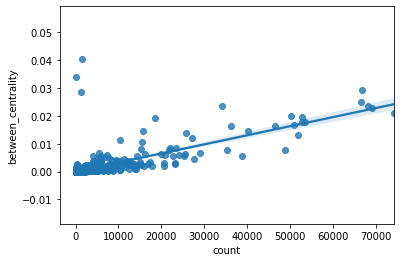

In [156]:
# does count relate to centrality? Yes!
sns.regplot(x="count", y="between_centrality", data=df_network)

### Merge data into main dataframe

In [384]:
clusters = list(df_network.partition.unique())

In [387]:
# exclude the small cluster 12
clusters = clusters[:12]

In [474]:
# make each cluster a column in df
for i in clusters:
    df[i]=0

In [555]:
# count for each project in which cluster it has how many skills
def skill_diversity(df,df_network):
    
    for index, row in df.skills.iteritems():
                if isinstance(row, list):
                    
                    for skill in row: 
                        try:
                        #print(index,row,skill)
                            partition = df_network[df_network["skills"]==skill].partition.item()
                            df.loc[index,(partition)] += 1
                        except:
                            print("missing",skill)
                            continue
                elif isinstance(row, str):
                    try:
                        partition = df_network[df_network["skills"]==row].partition.item()
                        df.loc[index,(partition)] += 1
                    except:
                        print("missing",row)
                        continue

                else:
                    print("missing")
    
    return 

In [540]:
# subset df_network to exclude cluster 12
df_network = df_network[df_network["partition"] != "12"]

In [ ]:
# function to multiprocess
from multiprocessing import  Pool

def parallelize_dataframe(df, func, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [556]:
skill_diversity(df,df_network)

missing ab-tasty
missing include-software-asset
missing translation-greek-french
missing usda
missing energy-certification
missing titles
missing essbase
missing fla
missing digital-word-processor
missing bullseye-business-solutions-kudos
missing resource-allocation
missing art-and-design
missing dymo-endicia
missing punk-rock
missing envoy
missing convert-experiences
missing unicentre
missing windsim
missing cc2640
missing human-body
missing asme-b31.3
missing saba-software-collaboration
missing hitfilm-express
missing river
missing content-marketing-strategy
missing rev360-revolutionehr
missing fleet-engineering-spatula
missing indian-cotton
missing conductive
missing teaching-serbian
missing full-production
missing musical-theatre
missing translation-italian-japanese
missing quilting
missing translation-russian-greek
missing translation-spanish-greek
missing lithography
missing children's-clothing
missing photographic-film
missing headgear
missing comsat
missing etching
missing voic

In [634]:
# bis index 433 Fehler

# df.loc[420:440,:]

In [598]:
# Test if it worked
for index, row in df.skills[0:434].iteritems():
        
        if isinstance(row, list):
            
            if len(df.skills[index]) == int(df.loc[index,"0":].sum()/5):
                continue
            else:
                print("Not matching")
                print(index,row)
                print(len(df.skills[index]),int(df.loc[index,"0":].sum()/5))
                
        elif isinstance(row, str):
            
            if 1 == int(df.loc[index,"0":].sum()/5):
                continue
                
            else:
                print("Not matching")
                print(index,row)
                print(int(df.loc[index,"0":].sum()/5))
                
        else:
            print("error")

In [ ]:
# Replace wrong counts (0:433) :

df.loc[0:433,"0":] = df.loc[0:433,"0":]/5
df.loc[:,"0":] = df.loc[:,"0":].astype(int)

In [637]:
df.to_json("full_data_3.json")

In [640]:
### Add skill diversity = in how many clusters does a project have skills
df["skill_diversity"] = df.astype(bool).sum(axis=1)-7

In [642]:
### Add specialization = highest number of skills in one cluster
df["specialization"]= df[["0","1","3","4","5","6","7","8","9","10","11"]].max(axis=1)

In [644]:
df["diversity_1"]=0
df["diversity_2"]=0
df["diversity_2+"]=0

In [687]:
df.skill_diversity.unique()

array([ 1,  2,  4,  5,  3,  6,  7,  8, 10,  9])

In [685]:
# Look at extreme cases
df[df["skill_diversity"]==10]

,skills,rate,category_1,category_2,date_2,SkillScore,skill_level,0,1,2,3,4,5,6,7,8,9,10,11,skill_diversity,specialization,diversity_1,diversity_2,diversity_2+,diversity_3
36457,"[adobe-illustrator, adobe-photoshop, content-w...",54.0,Sales & Marketing,Lead Generation,2019-09-07,62.342857,medium,2,4,1,2,2,2,6,1,0,1,2,0,10,6,0,0,0,1
279012,"[api, api-integration, bootstrap, cms, crm, cs...",49.0,"Web, Mobile & Software Dev",Web Development,2019-04-12,65.642857,high,9,23,1,6,1,2,1,0,1,4,2,0,10,23,0,0,0,1
363200,"[2d-animation, adaptive-web-design, adobe-digi...",80.0,IT & Networking,Other - IT & Networking,2018-12-13,59.528571,medium,3,4,6,3,6,5,6,1,0,5,2,0,10,6,0,0,0,1
723550,"[adobe-flash, adobe-pdf, advertising, amazon-w...",15.0,Admin Support,Personal / Virtual Assistant,2017-01-25,47.785714,low,4,3,1,30,6,21,4,7,0,1,1,0,10,30,0,0,0,1


In [673]:
# drop observations with skill diversity = -1 (13 observations)
df = df[df["skill_diversity"]!=-1]

In [668]:
df['skill_diversity'].replace(-1, 1,inplace=True) 

In [677]:
df['diversity_1'] = np.where(df['skill_diversity']==1, 1, 0)
df['diversity_2'] = np.where(df['skill_diversity']==2, 1, 0)
df['diversity_3'] = np.where(df['skill_diversity']>2, 1, 0)

/Users/oleteutloff/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Save Data

In [688]:
df.to_json("full_data_2.json")